<a href="https://colab.research.google.com/github/arthur-siqueira/data-mining-project/blob/main/sprint04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
# Mineração de Dados - Projeto

# Importar bibliotecas
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
np.random.seed(42)


In [32]:
# Carregar os arquivos CSV
fact_stocks = pd.read_csv("factStocks.csv")
dim_company = pd.read_csv("dimCompany.csv")
dim_time = pd.read_csv("dimTime.csv")

df = fact_stocks.merge(dim_company, on="keyCompany", how="left")
df = df.merge(dim_time[['keyTime', 'datetime']], on="keyTime", how="left")
df["datetime"] = pd.to_datetime(df["datetime"])

In [33]:
# printando dataset completo
df

,keyTime,keyCompany,openValueStock,closeValueStock,highValueStock,lowValueStock,quantityStock,stockCodeCompany,nameCompany,sectorCodeCompany,sectorCompany,segmentCompany,datetime
0,1355,18,45.80,45.80,45.80,45.80,916.00,ALPA4,ALPARGATAS,ICON,BM&FBOVESPA CONSUMER STOCK INDEX (ICON),SEGMENTS AND SECTORS,1998-03-16
1,1355,107,12.15,12.60,12.60,12.15,668420.00,CPLE3,COPEL,IDIV,BM&FBOVESPA DIVIDEND INDEX (IDIV),SEGMENTS AND SECTORS,1998-03-16
2,1355,108,17.00,17.50,17.50,16.95,3789172.00,CPLE6,COPEL,IDIV,BM&FBOVESPA DIVIDEND INDEX (IDIV),SEGMENTS AND SECTORS,1998-03-16
3,1355,604,299.00,299.00,299.00,299.00,59800.00,CTNM4,COTEMINAS,ITAG,SPECIAL TAG-ALONG STOCK INDEX (ITAG),CORPORATE GOVERNANCE,1998-03-16
4,1355,110,53.10,52.00,53.80,52.00,8331641.00,ELET3,ELETROBRAS,IDIV,BM&FBOVESPA DIVIDEND INDEX (IDIV),SEGMENTS AND SECTORS,1998-03-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...
680145,9680,95,33.27,32.92,33.60,32.76,93099839.00,YDUQ3,YDUQS PART,ICON,BM&FBOVESPA CONSUMER STOCK INDEX (ICON),SEGMENTS AND SECTORS,2020-12-30
680146,9668,522,82.04,82.09,83.00,81.50,26111.70,Z1OM34,ZOOM VIDEO,BDRX,UNSPONSORED BDR INDEX-GLOBAL (BDRX),SEGMENTS AND SECTORS,2020-12-18
680147,9671,522,81.99,82.80,88.47,81.99,726880.66,Z1OM34,ZOOM VIDEO,BDRX,UNSPONSORED BDR INDEX-GLOBAL (BDRX),SEGMENTS AND SECTORS,2020-12-21
680148,9672,522,84.15,82.99,84.54,82.00,53535.32,Z1OM34,ZOOM VIDEO,BDRX,UNSPONSORED BDR INDEX-GLOBAL (BDRX),SEGMENTS AND SECTORS,2020-12-22


In [34]:
# Mostrar tamanho de cada dataset
print("🔍 Tamanho dos arquivos:")
print(f"factStocks: {fact_stocks.shape[0]} linhas × {fact_stocks.shape[1]} colunas")
print(f"dimCompany: {dim_company.shape[0]} linhas × {dim_company.shape[1]} colunas")
print(f"dimTime: {dim_time.shape[0]} linhas × {dim_time.shape[1]} colunas\n")

🔍 Tamanho dos arquivos:
factStocks: 680150 linhas × 7 colunas
dimCompany: 607 linhas × 6 colunas
dimTime: 9680 linhas × 13 colunas



In [35]:
# Listar todas as variáveis (nomes das colunas)
print("Variáveis em factStocks:", fact_stocks.columns.tolist())
print("Variáveis em dimCompany:", dim_company.columns.tolist())
print("Variáveis em dimTime:", dim_time.columns.tolist(), '\n')

Variáveis em factStocks: ['keyTime', 'keyCompany', 'openValueStock', 'closeValueStock', 'highValueStock', 'lowValueStock', 'quantityStock']
Variáveis em dimCompany: ['keyCompany', 'stockCodeCompany', 'nameCompany', 'sectorCodeCompany', 'sectorCompany', 'segmentCompany']
Variáveis em dimTime: ['keyTime', 'datetime', 'dayTime', 'dayWeekTime', 'dayWeekAbbrevTime', 'dayWeekCompleteTime', 'monthTime', 'monthAbbrevTime', 'monthCompleteTime', 'bimonthTime', 'quarterTime', 'semesterTime', 'yearTime'] 



In [36]:
# Classificar variáveis quantitativas e qualitativas
def classificar_variaveis(df):
    quantitativas = df.select_dtypes(include=[np.number]).columns.tolist()
    qualitativas = df.select_dtypes(exclude=[np.number]).columns.tolist()
    return quantitativas, qualitativas

q_fact, qual_fact = classificar_variaveis(fact_stocks)
q_comp, qual_comp = classificar_variaveis(dim_company)
q_time, qual_time = classificar_variaveis(dim_time)

In [37]:
# Construir a tabela de resumo de variáveis por tipo

resumo = []

# Adiciona as variáveis de factStocks
for var in q_fact:
    resumo.append(["factStocks", var, "Quantitativa"])
for var in qual_fact:
    resumo.append(["factStocks", var, "Qualitativa"])

# Adiciona as variáveis de dimCompany
for var in q_comp:
    resumo.append(["dimCompany", var, "Quantitativa"])
for var in qual_comp:
    resumo.append(["dimCompany", var, "Qualitativa"])

# Adiciona as variáveis de dimTime
for var in q_time:
    resumo.append(["dimTime", var, "Quantitativa"])
for var in qual_time:
    resumo.append(["dimTime", var, "Qualitativa"])

# Cria o DataFrame
resumo_variaveis = pd.DataFrame(resumo, columns=["Dataset", "Variável", "Tipo"])

# Exibe a tabela
print("📊 Tabela resumo de variáveis por tipo:")
print(resumo_variaveis)

📊 Tabela resumo de variáveis por tipo:
       Dataset             Variável          Tipo
0   factStocks              keyTime  Quantitativa
1   factStocks           keyCompany  Quantitativa
2   factStocks       openValueStock  Quantitativa
3   factStocks      closeValueStock  Quantitativa
4   factStocks       highValueStock  Quantitativa
5   factStocks        lowValueStock  Quantitativa
6   factStocks        quantityStock  Quantitativa
7   dimCompany           keyCompany  Quantitativa
8   dimCompany     stockCodeCompany   Qualitativa
9   dimCompany          nameCompany   Qualitativa
10  dimCompany    sectorCodeCompany   Qualitativa
11  dimCompany        sectorCompany   Qualitativa
12  dimCompany       segmentCompany   Qualitativa
13     dimTime              keyTime  Quantitativa
14     dimTime              dayTime  Quantitativa
15     dimTime          dayWeekTime  Quantitativa
16     dimTime            monthTime  Quantitativa
17     dimTime          bimonthTime  Quantitativa
18     dimT

In [38]:
# Função para gerar estatísticas descritivas das ações por empresa
colunas_valores = ['openValueStock', 'closeValueStock', 'highValueStock', 'lowValueStock']

def estatisticas_empresa(nome_empresa):
    dados = df[df['nameCompany'] == nome_empresa][colunas_valores]
    estat = dados.describe().T
    estat['Mediana'] = dados.median()
    estat['Moda'] = dados.mode().iloc[0]
    estat = estat[['mean', 'Mediana', 'Moda', 'std', 'min', '25%', '50%', '75%', 'max']]
    estat.columns = ['Média', 'Mediana', 'Moda', 'Desvio Padrão', 'Mínimo',
                     '1º Quartil', '2º Quartil', '3º Quartil', 'Máximo']
    return estat.round(2)

## Análise Estatística de Empresas Específicas

Nesta seção, serão analisadas as ações de três grandes empresas brasileiras: **PETROBRAS**, **BANCO DO BRASIL** e **VALE**, com base nos valores de abertura, fechamento, máxima e mínima.


In [39]:
estat_petrobras = estatisticas_empresa("PETROBRAS")
estat_petrobras


,Média,Mediana,Moda,Desvio Padrão,Mínimo,1º Quartil,2º Quartil,3º Quartil,Máximo
openValueStock,58.99,33.46,50.0,77.20,4.20,19.97,33.46,56.89,514.0
closeValueStock,58.99,33.34,49.0,77.27,4.20,19.95,33.34,56.80,515.0
highValueStock,59.94,34.00,54.5,78.49,4.27,20.27,34.00,57.60,521.0
lowValueStock,57.99,32.78,55.0,75.86,4.12,19.66,32.78,56.00,509.0


In [40]:
estat_bb = estatisticas_empresa("BRASIL")
estat_bb


,Média,Mediana,Moda,Desvio Padrão,Mínimo,1º Quartil,2º Quartil,3º Quartil,Máximo
openValueStock,25.62,25.01,6.0,14.08,5.25,14.40,25.01,31.07,83.64
closeValueStock,25.61,25.03,30.0,14.08,5.10,14.35,25.03,31.07,83.15
highValueStock,26.04,25.45,6.0,14.27,5.40,14.70,25.45,31.55,85.70
lowValueStock,25.17,24.59,6.2,13.87,5.10,14.19,24.59,30.58,81.50


In [41]:
estat_vale = estatisticas_empresa("VALE")
estat_vale


,Média,Mediana,Moda,Desvio Padrão,Mínimo,1º Quartil,2º Quartil,3º Quartil,Máximo
openValueStock,51.92,47.21,49.0,29.77,8.75,32.35,47.21,60.00,181.8
closeValueStock,51.94,47.11,52.0,29.82,8.60,32.45,47.11,60.10,180.0
highValueStock,52.67,47.80,49.0,30.26,9.06,32.96,47.80,61.10,185.0
lowValueStock,51.20,46.58,51.5,29.41,8.60,31.94,46.58,59.13,175.0


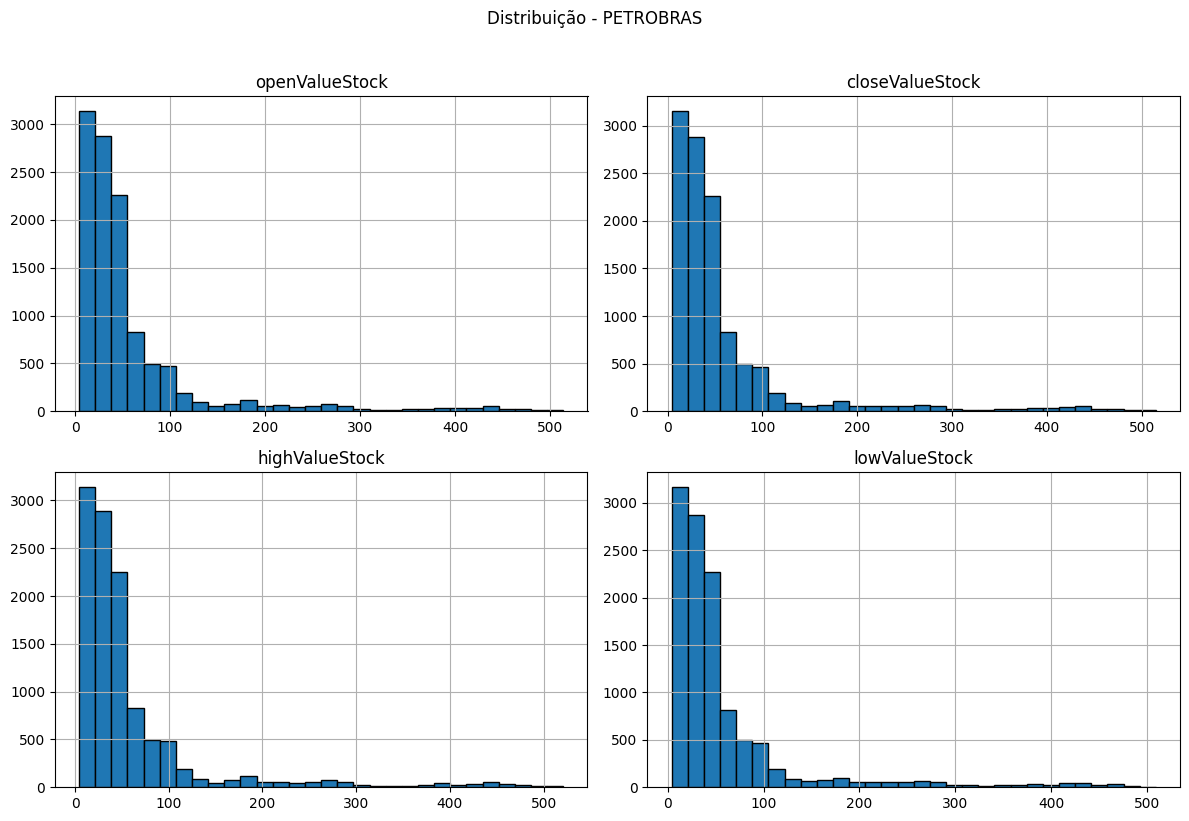

In [42]:
df[df['nameCompany'] == "PETROBRAS"][colunas_valores].hist(figsize=(12, 8), bins=30, edgecolor='black')
plt.suptitle("Distribuição - PETROBRAS", y=1.02)
plt.tight_layout()
plt.show()

A distribuição dos valores de abertura, fechamento, máximo e mínimo das ações da PETROBRAS é assimétrica à direita, com a maior parte dos registros concentrada abaixo de 100. Observam-se diversos valores extremos acima de 200, sugerindo a presença de outliers, possivelmente relacionados a eventos como desdobramentos de ações.

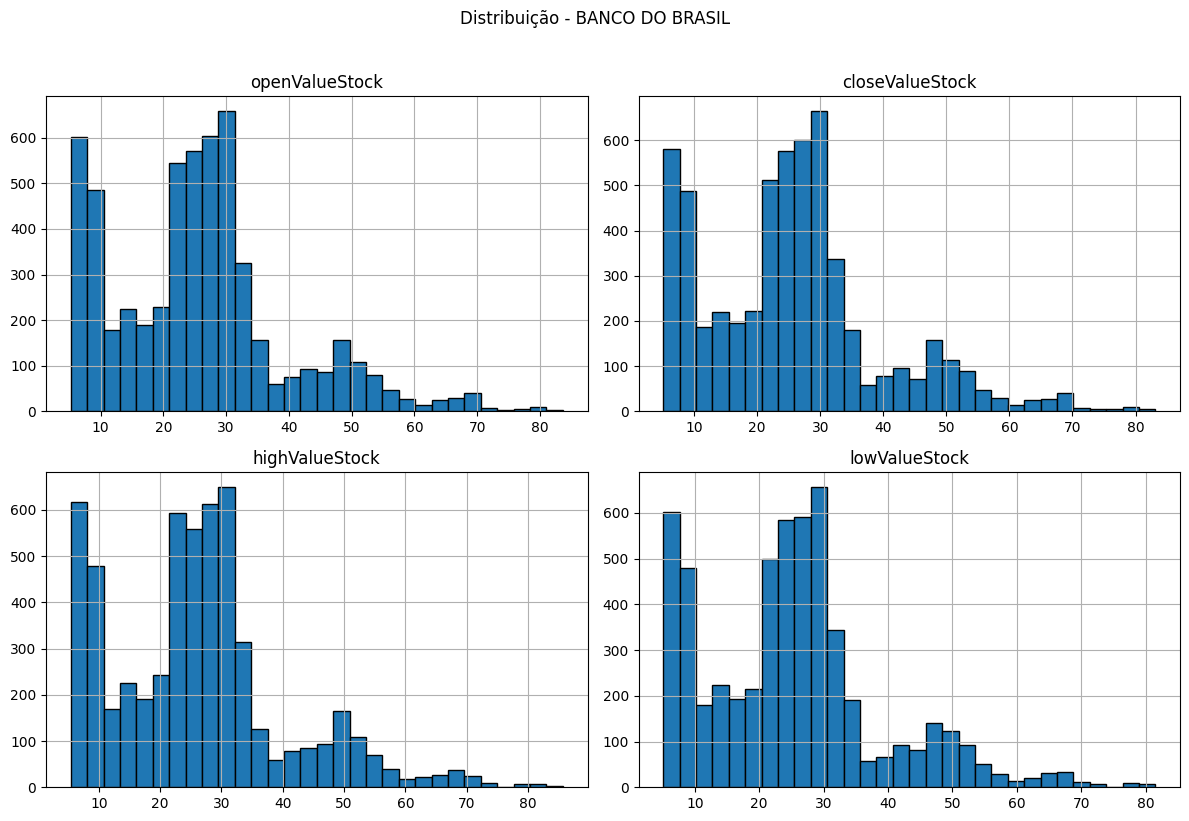

In [43]:
df[df['nameCompany'] == "BRASIL"][colunas_valores].hist(figsize=(12, 8), bins=30, edgecolor='black')
plt.suptitle("Distribuição - BANCO DO BRASIL", y=1.02)
plt.tight_layout()
plt.show()

Os valores de abertura, fechamento, máxima e mínima das ações do Banco do Brasil apresentam uma distribuição bimodal, indicando dois períodos distintos de preços predominantes — um grupo concentrado entre 10 e 20, e outro entre 25 e 35. Isso sugere possíveis mudanças estruturais no comportamento da ação ao longo do tempo.

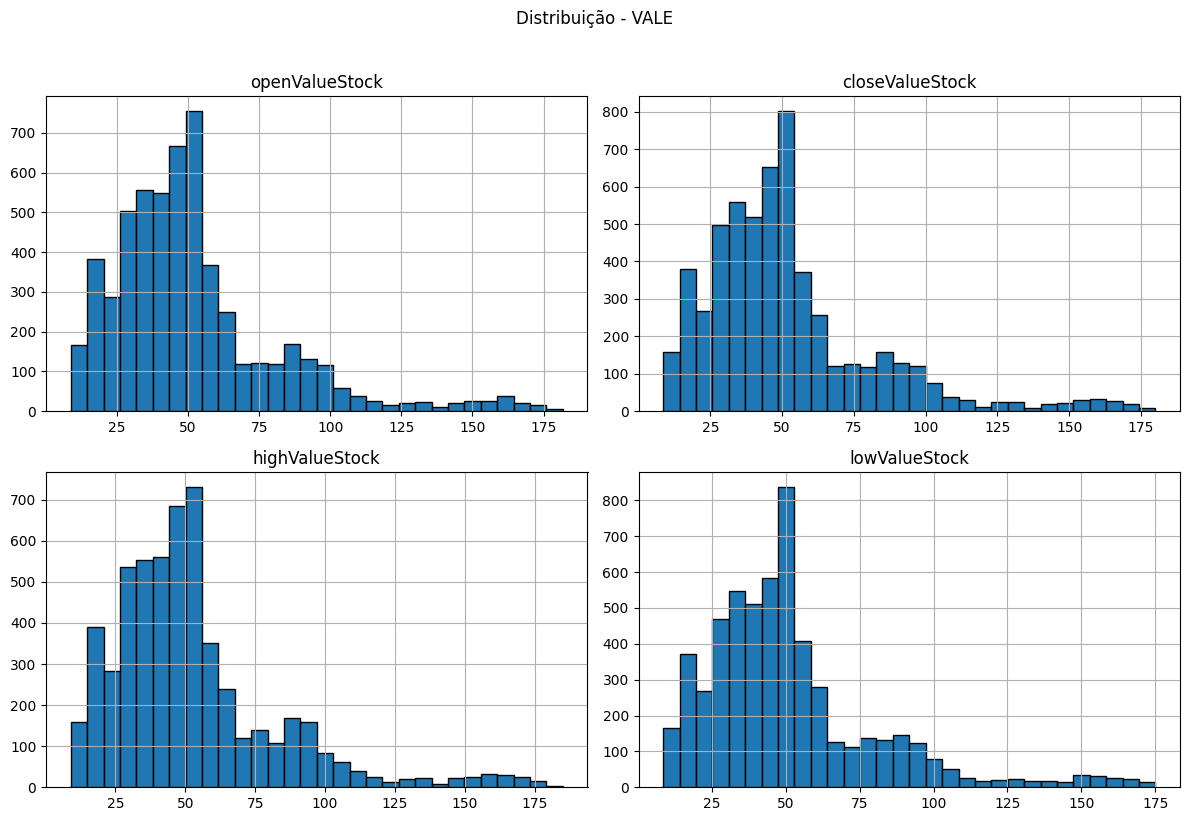

In [44]:
df[df['nameCompany'] == "VALE"][colunas_valores].hist(figsize=(12, 8), bins=30, edgecolor='black')
plt.suptitle("Distribuição - VALE", y=1.02)
plt.tight_layout()
plt.show()

A distribuição dos valores de ação da VALE apresenta uma concentração significativa entre 30 e 60, com cauda à direita e alguns outliers acima de 100. A forma assimétrica indica que, embora a maior parte dos preços tenha se mantido em uma faixa estável, houve períodos de valorização acentuada.

In [45]:
qualitativas = df.select_dtypes(exclude='number')[['sectorCompany']]
tabela_freq = qualitativas['sectorCompany'].value_counts().to_frame('Frequência Absoluta')
tabela_freq['Frequência Relativa (%)'] = (tabela_freq['Frequência Absoluta'] / len(qualitativas)) * 100
tabela_freq.round(2)

,Frequência Absoluta,Frequência Relativa (%)
sectorCompany,,
BM&FBOVESPA CONSUMER STOCK INDEX (ICON),154200,22.67
BM&FBOVESPA DIVIDEND INDEX (IDIV),127429,18.74
UNSPONSORED BDR INDEX-GLOBAL (BDRX),81006,11.91
SPECIAL CORPORATE GOVERNANCE STOCK INDEX (IGC),62981,9.26
BM&FBOVESPA BASIC MATERIALS INDEX (IMAT),61096,8.98
SMALLCAP INDEX (SMLL),34792,5.12
BM&FBOVESPA INDUSTRIALS INDEX (INDX),29493,4.34
NOVO MERCADO CORPORATE GOVERNANCE EQUITY INDEX (IGC-NM),29326,4.31
SPECIAL TAG-ALONG STOCK INDEX (ITAG),21418,3.15


- BM&FBOVESPA FINANCIALS INDEX (IFNC) =	Empresas do setor financeiro, como bancos, seguradoras e instituições de crédito.

- BM&FBOVESPA BASIC MATERIALS INDEX (IMAT) = Empresas ligadas à produção de matérias-primas, como mineração, siderurgia e papel & celulose.

- BM&FBOVESPA DIVIDEND INDEX (IDIV)	= Empresas com histórico consistente de distribuição de dividendos, voltadas ao investidor de renda.

- BM&FBOVESPA CONSUMER STOCK INDEX (ICON)	= Empresas do setor de consumo, como varejo, alimentos, vestuário, eletrônicos e serviços ao consumidor.

- BM&FBOVESPA INDUSTRIALS INDEX (INDX)	= Empresas da indústria de base, como construção, transporte, logística e manufatura.

- BM&FBOVESPA REAL ESTATE INDEX (IMOB)	= Empresas do setor imobiliário, como incorporadoras e administradoras de imóveis.

- BM&FBOVESPA ELECTRIC UTILITIES INDEX (IEE)	= Empresas de energia elétrica, geração, transmissão e distribuição.

- BM&FBOVESPA PUBLIC UTILITIES INDEX (UTIL)	= Empresas de utilidade pública além da energia, como saneamento e gás encanado.

- SPECIAL CORPORATE GOVERNANCE STOCK INDEX (IGC)	= Empresas que aderem voluntariamente a boas práticas de governança corporativa.

- NOVO MERCADO CORPORATE GOVERNANCE EQUITY INDEX (IGC-NM)	= Subconjunto do IGC composto apenas por empresas do Novo Mercado (o mais alto nível de governança).

- SPECIAL TAG-ALONG STOCK INDEX (ITAG)	= Empresas que oferecem maior proteção a acionistas minoritários em caso de venda do controle.

- MIDLARGECAP INDEX (MLCX)	= Empresas de médio e grande porte em valor de mercado (capitalização).

- SMALLCAP INDEX (SMLL)	= Empresas de menor porte listadas na B3 (baixa capitalização).

- UNSPONSORED BDR INDEX-GLOBAL (BDRX)	Brazilian Depositary Receipts (BDRs) = ações estrangeiras negociadas na B3.


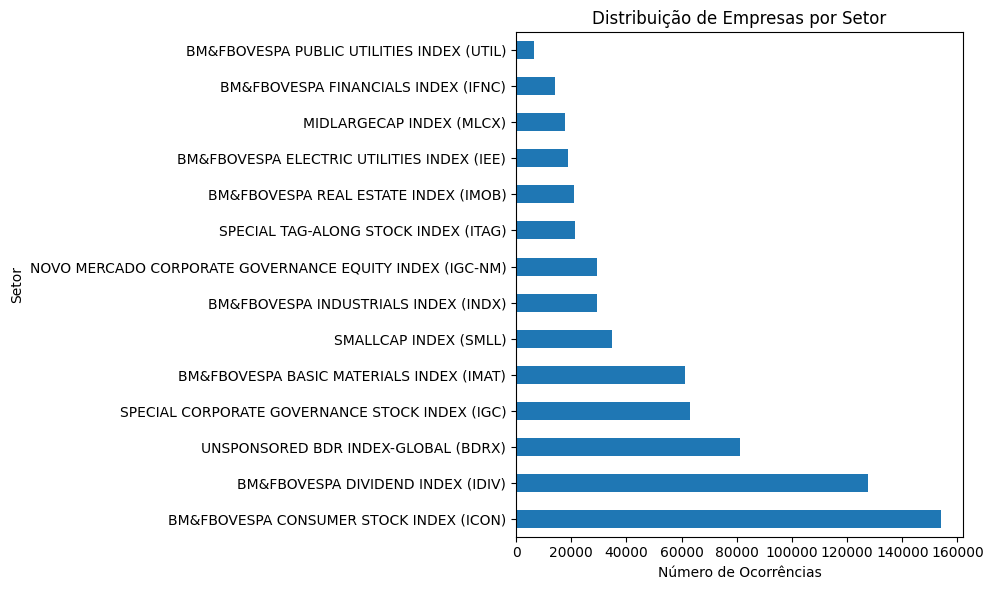

In [46]:
qualitativas['sectorCompany'].value_counts().plot(kind='barh', figsize=(10,6), title="Distribuição de Empresas por Setor")
plt.xlabel("Número de Ocorrências")
plt.ylabel("Setor")
plt.tight_layout()
plt.show()

O gráfico apresenta a distribuição das empresas da base de dados conforme os setores da B3. Observa-se que os setores BM&FBOVESPA CONSUMER STOCK INDEX (ICON) e DIVIDEND INDEX (IDIV) concentram a maior parte das ocorrências, representando empresas com forte presença no consumo e na distribuição de dividendos. Setores como UTILITIES e FINANCIALS aparecem com participação menor.

In [47]:
df['segmentCompany'].value_counts()

,count
segmentCompany,
SEGMENTS AND SECTORS,566425
CORPORATE GOVERNANCE,113725


CORPORATE GOVERNANCE:	Empresas listadas em segmentos que seguem boas práticas de governança corporativa da B3, como Novo Mercado, Nível 1, Nível 2, etc. Geralmente indicam transparência, proteção ao acionista minoritário e acesso a capital mais sólido.

SEGMENTS AND SECTORS: Empresas listadas em segmentos tradicionais, ou agrupadas apenas por setores de atuação (como consumo, energia, financeiro), sem exigências específicas de governança.

In [48]:
# Calcular total de valores nulos por coluna
faltantes = df.isnull().sum()

# Calcular percentual de nulos por coluna
percentuais = (faltantes / len(df)) * 100

# Criar DataFrame de diagnóstico
diagnostico = pd.DataFrame({
    'Faltantes': faltantes,
    'Percentual (%)': percentuais.map(lambda x: f"{x:.2f}%")  # Formata corretamente
})

# Exibir apenas colunas com valores faltantes ou tudo (com .round se preferir)
diagnostico

,Faltantes,Percentual (%)
keyTime,0,0.00%
keyCompany,0,0.00%
openValueStock,0,0.00%
closeValueStock,0,0.00%
highValueStock,0,0.00%
lowValueStock,0,0.00%
quantityStock,0,0.00%
stockCodeCompany,0,0.00%
nameCompany,0,0.00%
sectorCodeCompany,0,0.00%


Foi realizado o diagnóstico de valores ausentes no conjunto de dados. Conforme evidenciado, nenhuma coluna apresentou dados faltantes, o que elimina a necessidade de imputações ou exclusões nesse momento.

In [49]:
print(f"Total de linhas duplicadas: {df.duplicated().sum()}")

Total de linhas duplicadas: 0


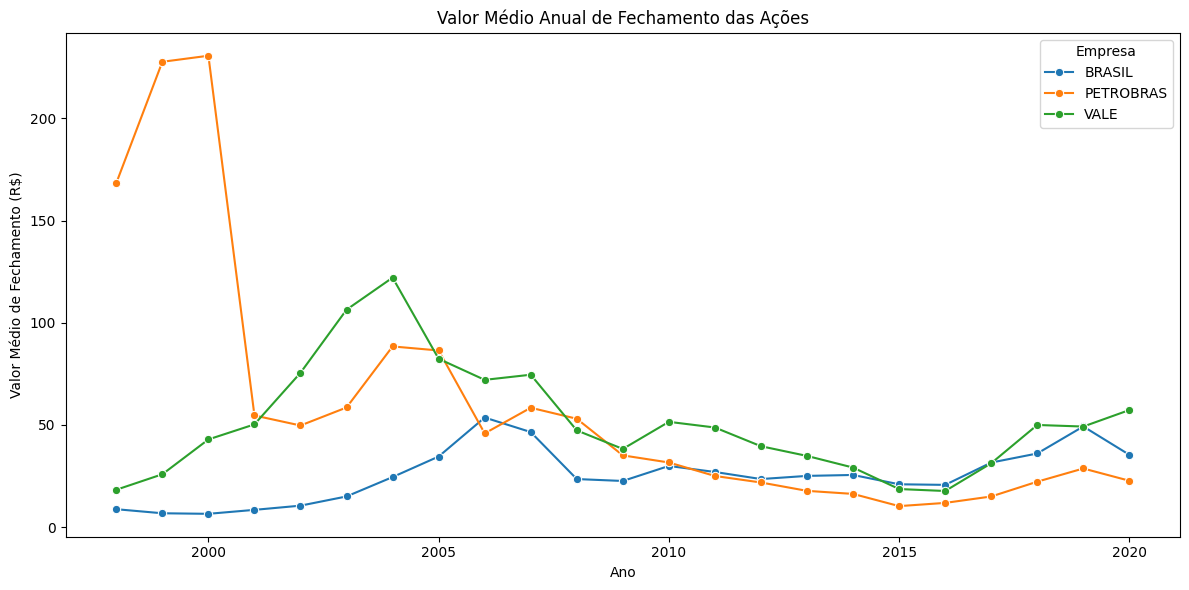

In [50]:
# Filtrar apenas as empresas desejadas
df_emp = df[df['nameCompany'].isin(["PETROBRAS", "BRASIL", "VALE"])].copy()

# Extrair apenas o ano da data
df_emp['ano'] = df_emp['datetime'].dt.year

# Calcular o valor médio anual de fechamento por empresa
media_anual = df_emp.groupby(["ano", "nameCompany"])["closeValueStock"].mean().reset_index()

# Plotar o gráfico de linha
plt.figure(figsize=(12, 6))
sns.lineplot(data=media_anual, x="ano", y="closeValueStock", hue="nameCompany", marker="o")
plt.title("Valor Médio Anual de Fechamento das Ações")
plt.xlabel("Ano")
plt.ylabel("Valor Médio de Fechamento (R$)")
plt.xticks(rotation=0)
plt.tight_layout()
plt.legend(title="Empresa")
plt.show()

O gráfico mostra a evolução do valor médio anual de fechamento das ações de PETROBRAS, BANCO DO BRASIL e VALE. Observa-se que a VALE apresentou, no geral, os maiores valores médios ao longo do tempo, com destaque para um pico em 2008. A PETROBRAS registrou valores extremamente altos no início da série, provavelmente relacionados a dados históricos não ajustados por eventos como desdobramentos. O BANCO DO BRASIL manteve uma trajetória mais estável e crescente até 2010, com leve recuo nos anos seguintes.

In [51]:
df[df['nameCompany'].isin(['PETROBRAS', 'BRASIL', 'VALE'])][['nameCompany', 'sectorCompany']].drop_duplicates()


,nameCompany,sectorCompany
12,PETROBRAS,MIDLARGECAP INDEX (MLCX)
16,BRASIL,BM&FBOVESPA DIVIDEND INDEX (IDIV)
19,PETROBRAS,BM&FBOVESPA DIVIDEND INDEX (IDIV)
24,VALE,BM&FBOVESPA BASIC MATERIALS INDEX (IMAT)


In [52]:
df[df['nameCompany'].isin(['PETROBRAS', 'BRASIL', 'VALE'])][['nameCompany', 'segmentCompany']].drop_duplicates()

,nameCompany,segmentCompany
12,PETROBRAS,SEGMENTS AND SECTORS
16,BRASIL,SEGMENTS AND SECTORS
24,VALE,SEGMENTS AND SECTORS


# Previsão da ação do Banco do Brasil (2015-2020)

Estudo preditivo focado no Banco do Brasil, dividindo o histórico em:

- **Treino:** do início até 31/12/2014
- **Teste:** de 2015 a 2020

Utiliza um modelo ARIMA para prever a série temporal e avaliamos o desempenho com o MAPE.

In [53]:
# filtro e ordenação

bb_df = df[df['nameCompany'] == "BRASIL"].copy()
bb_df = bb_df.sort_values("datetime")
bb_df[['datetime', 'closeValueStock']].head()


,datetime,closeValueStock
16,1998-03-16,8.00
30,1998-03-17,8.35
63,1998-03-18,8.30
90,1998-03-19,8.39
117,1998-03-20,8.45


In [54]:
# separando dados de teste e treino

treino_df = bb_df[bb_df['datetime'] < "2015-01-01"]
teste_df = bb_df[(bb_df['datetime'] >= "2015-01-01") & (bb_df['datetime'] < "2021-01-01")]
len(treino_df), len(teste_df)


(4152, 1483)

In [55]:
# treinando modelo arima

serie_treino = treino_df['closeValueStock']
modelo = ARIMA(serie_treino, order=(1,1,1))
resultado = modelo.fit()


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Usin

In [56]:
# previsão

n_periods = len(teste_df)
forecast = resultado.forecast(steps=n_periods)
forecast.index = teste_df.index

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


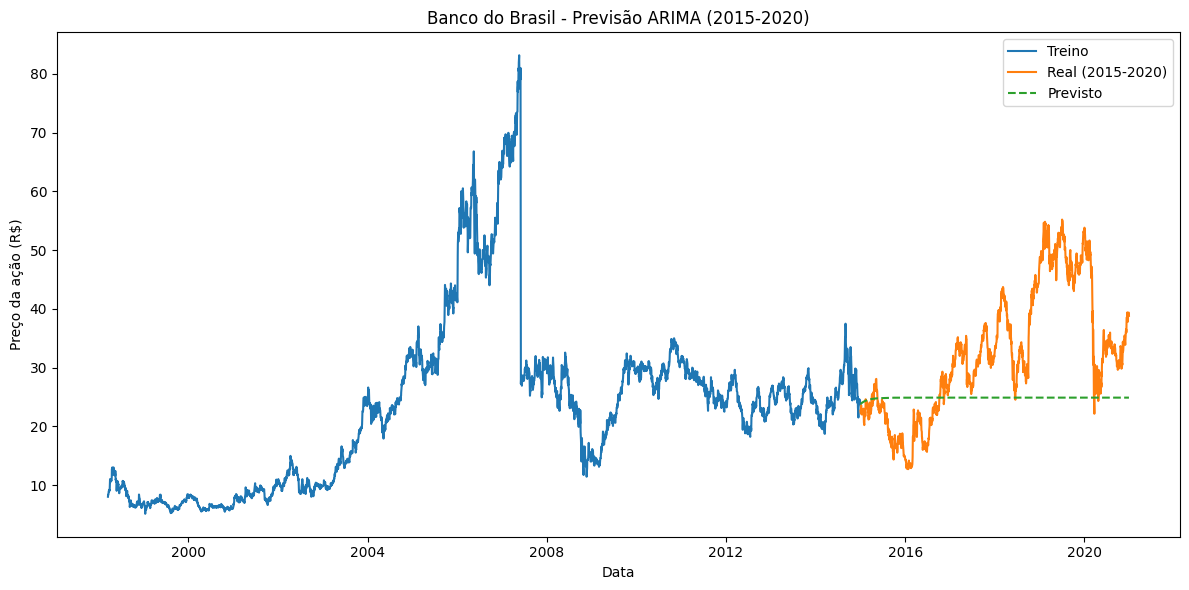

In [57]:
plt.figure(figsize=(12,6))
plt.plot(treino_df['datetime'], treino_df['closeValueStock'], label="Treino")
plt.plot(teste_df['datetime'], teste_df['closeValueStock'], label="Real (2015-2020)")
plt.plot(teste_df['datetime'], forecast, '--', label="Previsto")
plt.title("Banco do Brasil - Previsão ARIMA (2015-2020)")
plt.xlabel("Data")
plt.ylabel("Preço da ação (R$)")
plt.legend()
plt.tight_layout()
plt.show()

In [58]:
# Avaliação do modelo MAPE

mape = mean_absolute_percentage_error(teste_df['closeValueStock'], forecast)
print(f"MAPE: {mape:.2%}")

MAPE: 29.99%


In [59]:
comparacao_df = pd.DataFrame({
    "Data": teste_df['datetime'].values,
    "Real": teste_df['closeValueStock'].values,
    "Previsto": forecast.values
})

comparacao_df["Erro Absoluto"] = (comparacao_df["Real"] - comparacao_df["Previsto"]).abs()
comparacao_df["Erro %"] = comparacao_df["Erro Absoluto"] / comparacao_df["Real"] * 100

comparacao_df.head()


,Data,Real,Previsto,Erro Absoluto,Erro %
0,2015-01-02,22.65,23.796323,1.146323,5.061029
1,2015-01-05,22.18,23.822018,1.642018,7.403147
2,2015-01-06,22.49,23.847100,1.357100,6.034235
3,2015-01-07,23.48,23.871582,0.391582,1.667728
4,2015-01-08,23.56,23.895481,0.335481,1.423943


## Conclusão

Foi ajustado um ARIMA(1,1,1) no histórico do Banco do Brasil até 2014 e feita previsão para o período de 2015 a 2020.
A taxa de erro percentual médio (MAPE) foi calculada, indicando o nível de acerto do modelo no horizonte escolhido.

Previsão vale e petrobras


In [60]:
# Funções
def ensure_unique_daily(series_df: pd.DataFrame, target_col: str):
    return (series_df.groupby('datetime', as_index=True).agg({target_col:'last'}).sort_index()[target_col].astype(float))

def make_features(series, lags=(1,5,20), rolls=(5,20,60)):
    s = series.copy(); feats = pd.DataFrame(index=s.index)
    for L in lags: feats[f'lag_{L}'] = s.shift(L)
    for W in rolls:
        feats[f'roll_mean_{W}'] = s.shift(1).rolling(W).mean()
        feats[f'roll_std_{W}']  = s.shift(1).rolling(W).std()
    feats['y'] = s.values
    return feats.dropna()

def split_by_date(feats, end_train='2014-12-31', start_test='2015-01-01', end_test='2020-12-31'):
    idx = feats.index
    tr = feats.loc[idx <= pd.to_datetime(end_train)]
    te = feats.loc[(idx >= pd.to_datetime(start_test)) & (idx <= pd.to_datetime(end_test))]
    return tr, te

def metrics(y_true, y_pred):
    # RMSE
    try:
        rmse = mean_squared_error(y_true, y_pred, squared=False)  # versões novas
    except TypeError:
        import numpy as np
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))        # fallback

    mae  = mean_absolute_error(y_true, y_pred)

    # MAPE
    try:
        mape = mean_absolute_percentage_error(y_true, y_pred)
    except Exception:
        import numpy as np
        y_true = np.asarray(y_true, dtype=float)
        y_pred = np.asarray(y_pred, dtype=float)
        eps = 1e-8
        mape = np.mean(np.abs((y_true - y_pred) / np.where(np.abs(y_true) < eps, eps, y_true)))
    return {'RMSE': rmse, 'MAE': mae, 'MAPE': mape}



In [61]:
def fit_predict_models_for_company(df_full, company_name, target_col='closeValueStock',
                                   lags=(1,5,20), rolls=(5,20,60),
                                   end_train='2014-12-31', start_test='2015-01-01', end_test='2020-12-31'):
    sub = df_full[df_full['nameCompany']==company_name][['datetime', target_col]].dropna().sort_values('datetime')
    y_series = ensure_unique_daily(sub, target_col)
    feats = make_features(y_series, lags=lags, rolls=rolls)
    train, test = split_by_date(feats, end_train=end_train, start_test=start_test, end_test=end_test)
    Xtr, ytr, Xte, yte = train.drop(columns=['y']), train['y'], test.drop(columns=['y']), test['y']

    gbr = GradientBoostingRegressor(random_state=42).fit(Xtr, ytr)
    gbr_pred = pd.Series(gbr.predict(Xte), index=yte.index); gbr_m = metrics(yte.values, gbr_pred.values)

    mlp = Pipeline([('scaler', StandardScaler()), ('mlp', MLPRegressor(hidden_layer_sizes=(64,64), activation='relu',
                 alpha=1e-3, learning_rate_init=1e-3, max_iter=500, early_stopping=True, random_state=42))]).fit(Xtr, ytr)
    mlp_pred = pd.Series(mlp.predict(Xte), index=yte.index); mlp_m = metrics(yte.values, mlp_pred.values)

    df_gbr = pd.DataFrame({'datetime': yte.index, 'Real': yte.values, 'Previsto': gbr_pred.values})
    df_mlp = pd.DataFrame({'datetime': yte.index, 'Real': yte.values, 'Previsto': mlp_pred.values})
    return (gbr_m, mlp_m), (df_gbr, df_mlp)

In [62]:
# Rodar para PETROBRAS e VALE
empresas = ['PETROBRAS','VALE']
resultados = []; predicoes = {}
for nome in empresas:
    (m_gbr, m_mlp), (df_gbr, df_mlp) = fit_predict_models_for_company(df, nome)
    resultados += [{'Empresa':nome,'Modelo':'Ensemble_GBR',**m_gbr},{'Empresa':nome,'Modelo':'Neural_MLP',**m_mlp}]
    predicoes[nome] = {'Ensemble_GBR':df_gbr, 'Neural_MLP':df_mlp}
metricas_df = pd.DataFrame(resultados).sort_values(['Empresa','MAPE']).reset_index(drop=True)
metricas_df

,Empresa,Modelo,RMSE,MAE,MAPE
0,PETROBRAS,Neural_MLP,1.527655,1.216471,0.095626
1,PETROBRAS,Ensemble_GBR,2.350713,1.650231,0.159552
2,VALE,Ensemble_GBR,1.324006,0.841292,0.028072
3,VALE,Neural_MLP,1.309831,0.919723,0.031414


In [63]:
# Exportar CSVs
out = Path('.')
metricas_df.to_csv(out / 'metricas_PETROBRAS_VALE_2015_2020.csv', index=False)
for empresa, modelos in predicoes.items():
    for modelo, dfp in modelos.items():
        fname = f'predicoes_{empresa}_{modelo}_2015_2020.csv'
        dfp.to_csv(out / fname, index=False)
        print('Salvo:', fname)

Salvo: predicoes_PETROBRAS_Ensemble_GBR_2015_2020.csv
Salvo: predicoes_PETROBRAS_Neural_MLP_2015_2020.csv
Salvo: predicoes_VALE_Ensemble_GBR_2015_2020.csv
Salvo: predicoes_VALE_Neural_MLP_2015_2020.csv


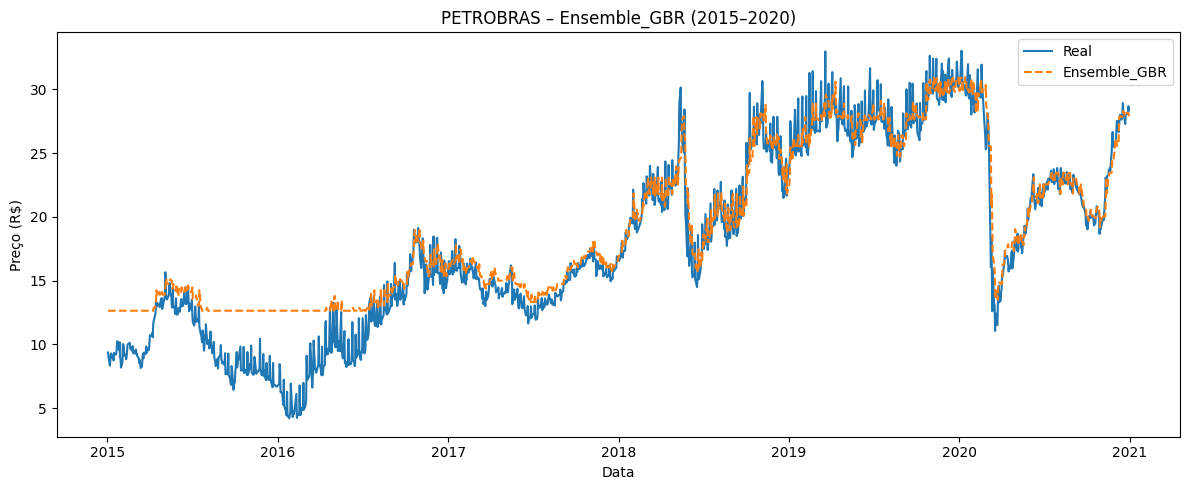

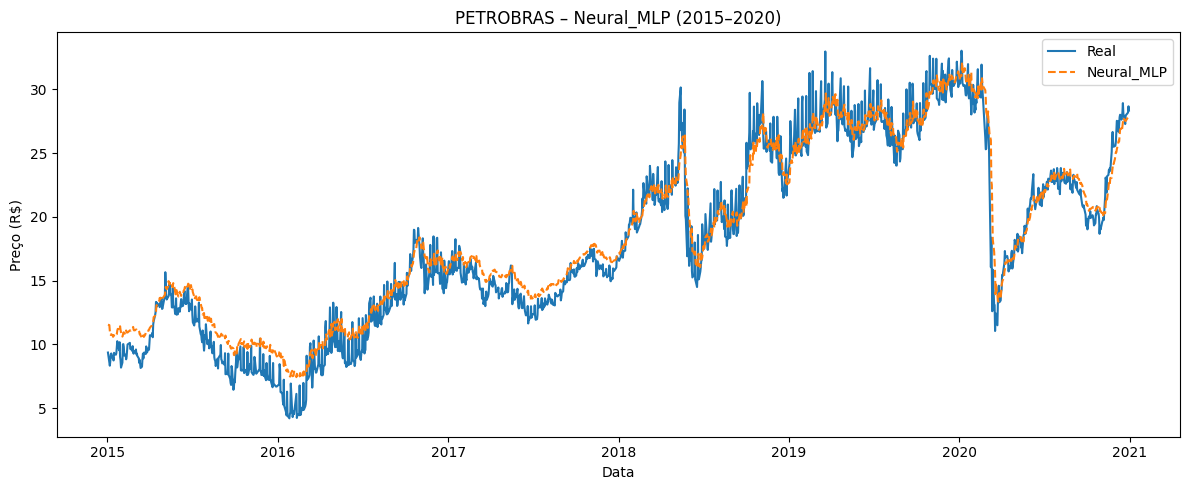

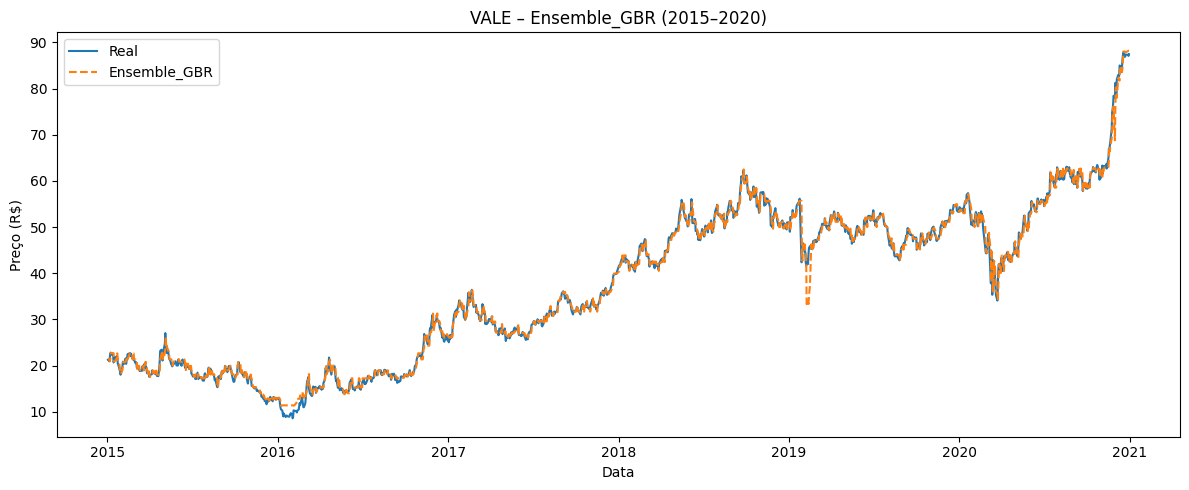

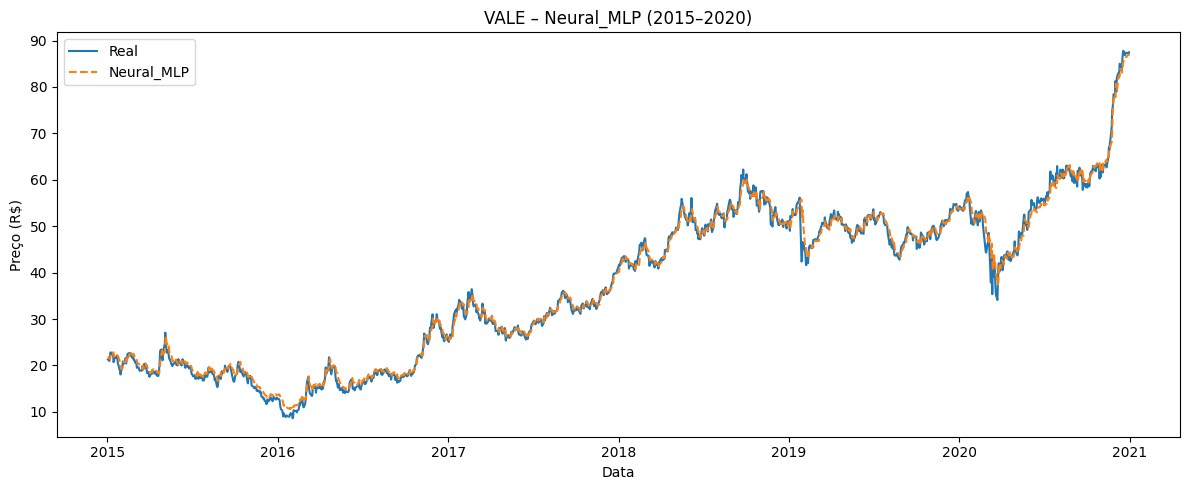

In [65]:
def plot_pred(company, model, predicoes, figsize=(12,5), save=False, outdir="figs"):
    df_plot = predicoes[company][model].copy().sort_values("datetime")
    x = df_plot["datetime"] if "datetime" in df_plot.columns else df_plot.index

    plt.figure(figsize=figsize)
    plt.plot(x, df_plot["Real"], label="Real")
    plt.plot(x, df_plot["Previsto"], "--", label=model)
    plt.title(f"{company} – {model} (2015–2020)")
    plt.xlabel("Data"); plt.ylabel("Preço (R$)")
    plt.legend(); plt.tight_layout()

    if save:
        os.makedirs(outdir, exist_ok=True)
        fname = f"{company}_{model}_2015_2020.png".replace(" ", "")
        plt.savefig(os.path.join(outdir, fname), dpi=150)
    plt.show()

plot_pred("PETROBRAS", "Ensemble_GBR", predicoes)
plot_pred("PETROBRAS", "Neural_MLP", predicoes)

plot_pred("VALE", "Ensemble_GBR", predicoes)
plot_pred("VALE", "Neural_MLP", predicoes)